# Логистическая регрессия. Практическая работа

## Цель практической работы

Вы уже делали задание, в котором с помощью метода ближайших соседей оценивали склонность клиента банка откликнуться или не откликнуться на предложение.

В этом практическом задании ваши цели:
*  решить эту же задачу с помощью логистической регрессии;
*  потренироваться в подборе порога; 
*  потренироваться в подборе гиперпараметров модели.

## Что входит в работу

*  Загрузить данные для задачи.
*  Обучить метод ближайших соседей с заданным количеством соседей k, вычислить метрики.
*  Обучить логистическую регрессию с параметрами по умолчанию, вычислить метрики.
*  Подобрать порог модели, вычислить метрики.
*  Подобрать гиперпараметр С (константа регуляризации) модели, вычислить метрики.

## Что оценивается

*  Выполнены все этапы задания: код запускается, отрабатывает без ошибок; подробно и обоснованно написаны текстовые выводы, где это требуется.

## Формат сдачи
Выполните предложенные задания — впишите свой код (или, если требуется, текст) в ячейки после комментариев. 

*Комментарии — это текст, который начинается с символа #. Например: # ваш код здесь.*

Сохраните изменения, используя опцию Save and Checkpoint из вкладки меню File или кнопку Save and Checkpoint на панели инструментов. Итоговый файл в формате .ipynb (файл Jupyter Notebook) загрузите в личный кабинет и отправьте на проверку.

In [1]:
# подключим библиотеки
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from IPython.display import display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, roc_auc_score


import warnings
warnings.filterwarnings("ignore")

In [2]:
# считаем данные
data = pd.read_csv('ClientsData.csv')

In [4]:
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


In [5]:
data.describe()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
count,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000,15223.000000
mean,40.406096,0.909610,0.134468,0.654536,1.099389,0.645208,13853.836323,1.387769,0.751889,0.195362,0.119030
std,11.601068,0.286748,0.341165,0.475535,0.995411,0.812252,9015.467617,0.793566,0.988499,0.685022,0.323835
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,1.000000,0.000000,0.000000,0.000000
25%,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,8000.000000,1.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,0.000000,1.000000,1.000000,0.000000,12000.000000,1.000000,0.000000,0.000000,0.000000
75%,50.000000,1.000000,0.000000,1.000000,2.000000,1.000000,17000.000000,2.000000,1.000000,0.000000,0.000000
max,67.000000,1.000000,1.000000,1.000000,10.000000,7.000000,250000.000000,11.000000,11.000000,13.000000,1.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                15223 non-null  int64  
 1   SOCSTATUS_WORK_FL  15223 non-null  int64  
 2   SOCSTATUS_PENS_FL  15223 non-null  int64  
 3   GENDER             15223 non-null  int64  
 4   CHILD_TOTAL        15223 non-null  int64  
 5   DEPENDANTS         15223 non-null  int64  
 6   PERSONAL_INCOME    15223 non-null  float64
 7   LOAN_NUM_TOTAL     15223 non-null  int64  
 8   LOAN_NUM_CLOSED    15223 non-null  int64  
 9   LOAN_DLQ_NUM       15223 non-null  int64  
 10  TARGET             15223 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.3 MB


In [7]:
data.LOAN_DLQ_NUM.unique()

array([ 2,  1,  0,  3,  4,  5,  6,  7,  8, 13,  9, 10, 12, 11],
      dtype=int64)

In [8]:
# Проверим распределение в долях значений в целевой переменной - target отклик на маркетинговую кампанию
global_mean = data.TARGET.mean()
round(global_mean, 3)

0.119

In [9]:
categorical = ['SOCSTATUS_WORK_FL', 'SOCSTATUS_PENS_FL', 'GENDER',
                   'CHILD_TOTAL', 'DEPENDANTS', 'LOAN_NUM_TOTAL', 'LOAN_NUM_CLOSED', 'LOAN_DLQ_NUM']

In [10]:
for col in categorical:
    data_group = data.groupby(by=col).TARGET.agg(['mean'])
    data_group['diff'] = data_group['mean'] - global_mean
    data_group['risk'] = data_group['mean'] / global_mean
    display(data_group)

,mean,diff,risk
SOCSTATUS_WORK_FL,,,
0,0.038517,-0.080513,0.323593
1,0.127031,0.008001,1.067216


,mean,diff,risk
SOCSTATUS_PENS_FL,,,
0,0.129857,0.010827,1.090959
1,0.049340,-0.069690,0.414520


,mean,diff,risk
GENDER,,,
0,0.132725,0.013694,1.115050
1,0.111802,-0.007228,0.939277


,mean,diff,risk
CHILD_TOTAL,,,
0,0.118379,-0.000652,0.994526
1,0.116572,-0.002459,0.979343
2,0.116908,-0.002122,0.982171
3,0.138924,0.019893,1.167127
4,0.157895,0.038864,1.326507
5,0.186441,0.067410,1.566328
6,0.083333,-0.035697,0.700101
7,0.000000,-0.119030,0.000000
8,0.000000,-0.119030,0.000000


,mean,diff,risk
DEPENDANTS,,,
0,0.106978,-0.012053,0.898744
1,0.124807,0.005777,1.048531
2,0.140286,0.021256,1.178574
3,0.201646,0.082616,1.694072
4,0.214286,0.095255,1.800260
5,0.600000,0.480970,5.040728
6,0.250000,0.130970,2.100304
7,0.000000,-0.119030,0.000000


,mean,diff,risk
LOAN_NUM_TOTAL,,,
1,0.126240,0.007210,1.060571
2,0.099506,-0.019524,0.835973
3,0.099885,-0.019145,0.839157
4,0.087273,-0.031758,0.733197
5,0.088235,-0.030795,0.741284
6,0.055556,-0.063475,0.466734
7,0.142857,0.023827,1.200173
8,0.333333,0.214303,2.800405
11,0.000000,-0.119030,0.000000


,mean,diff,risk
LOAN_NUM_CLOSED,,,
0,0.140418,0.021388,1.179685
1,0.102710,-0.016321,0.862885
2,0.088136,-0.030895,0.740446
3,0.079602,-0.039428,0.668753
4,0.089109,-0.029922,0.748623
5,0.048387,-0.070643,0.406510
6,0.115385,-0.003646,0.969371
7,0.000000,-0.119030,0.000000
8,0.500000,0.380970,4.200607


,mean,diff,risk
LOAN_DLQ_NUM,,,
0,0.109240,-0.009791,0.917748
1,0.187147,0.068116,1.572261
2,0.207143,0.088112,1.740251
3,0.166667,0.047636,1.400202
4,0.145833,0.026803,1.225177
5,0.205128,0.086098,1.723326
6,0.187500,0.068470,1.575228
7,0.142857,0.023827,1.200173
8,0.000000,-0.119030,0.000000


In [15]:
#Создадим дополнительную переменную доход с учетом иждивенцев (переменая DEPENDANTS)
data_new = data.copy()
data_new['INCOME_ON_DEPENDANTS'] = data_new.apply(lambda x: x['PERSONAL_INCOME'] / (x['DEPENDANTS'] + 1) if x['DEPENDANTS'] > 0
                                                else x['PERSONAL_INCOME'], axis=1)

In [16]:
data_new

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET,INCOME_ON_DEPENDANTS
0,49,1,0,1,2,1,5000.0,1,1,2,0,2500.0
1,32,1,0,1,3,3,12000.0,1,1,1,0,3000.0
2,52,1,0,1,4,0,9000.0,2,1,0,0,9000.0
3,39,1,0,1,1,1,25000.0,1,1,3,0,12500.0
4,30,1,0,0,0,0,12000.0,2,1,2,0,12000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15218,25,1,0,0,1,1,12000.0,3,2,0,0,6000.0
15219,51,1,0,1,2,0,10000.0,1,0,0,0,10000.0
15220,22,1,0,1,1,1,6000.0,1,0,0,0,3000.0
15221,60,0,1,1,2,0,4500.0,1,0,0,0,4500.0


В этом ноутбуке нам придётся подбирать гиперпараметры модели, а ещё порог. Поэтому, чтобы не переобучиться, разобъём данные на трейн, валидацию и тест.

*  Обучать модели будем на тренировочных данных.
*  Подбирать необходимые величины — по валидации.
*  Оценивать качество — на тесте.

In [17]:
# разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split

X = data_new.drop('TARGET', axis=1)
y = data_new['TARGET']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=123)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, train_size=0.7, random_state=123)

В задании по методу ближайших соседей было найдено, что оптимальное число соседей k = 9.

Обучите на тренировочных данных KNN с k = 9 и выведите матрицу ошибок, а также значение метрик precision и recall на тестовых данных.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [19]:
# ваш код здесь
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(Xtrain, ytrain)

KNeighborsClassifier(n_neighbors=9)

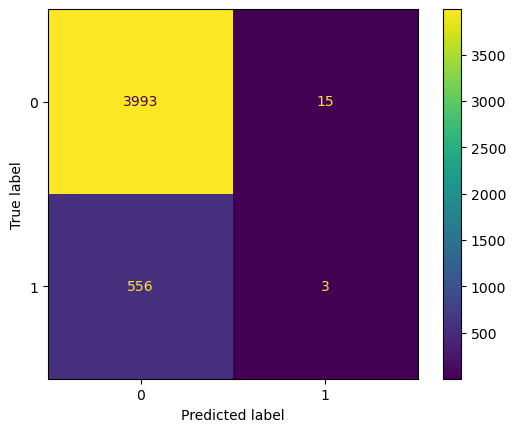

In [20]:
cm = confusion_matrix(ytest, knn.predict(Xtest), labels=knn.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_)
disp.plot()
plt.show()

In [21]:
precision = precision_score(ytest, knn.predict(Xtest))
precision

0.16666666666666666

In [22]:
recall = recall_score(ytest, knn.predict(Xtest))
recall

0.005366726296958855

Какой вывод можно сделать:
- для класса 0 — клиент не откликнулся — мы получили достаточно высокие значения TP в том числе потому, что представителей этого класса больше;
- для класса 1 — клиент откликнулся — мы получили низкие значения TN.

Поэтому значения precision и recall низкие. Модель даёт неудовлетворительные результаты, так как находит мало клиентов, которые откликнутся на предложение.



Обучите логистическую регрессию с параметрами по умолчанию и посмотрите на метрики.

Везде дальше при оценке метрик надо выводить confusion_matrix, precision и recall.

In [23]:
from sklearn.linear_model import LogisticRegression

# ваш код здесь
logreg = LogisticRegression()
logreg.fit(Xtrain, ytrain)

y_pred_train = logreg.predict(Xtrain)
y_pred_test = logreg.predict(Xtest)

In [24]:
confusion_matrix(ytest, y_pred_test)

array([[4003,    5],
       [ 559,    0]], dtype=int64)

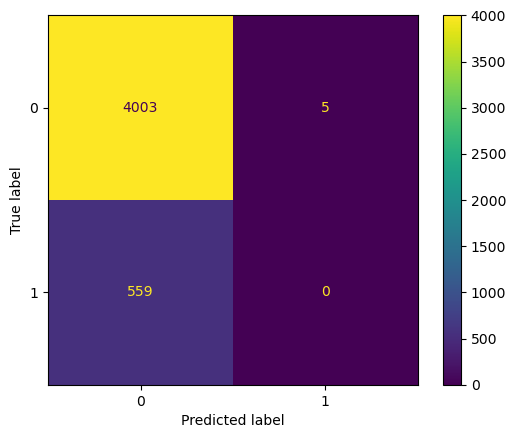

In [25]:
cm = confusion_matrix(ytest, y_pred_test, labels=logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot()
plt.show()

In [26]:
confusion_matrix(ytest, logreg.predict(Xtest), normalize='all')

array([[0.87650536, 0.00109481],
       [0.12239982, 0.        ]])

In [27]:
y_pred_test[: 30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [28]:
precision = precision_score(ytest, y_pred_test)
recall = recall_score(ytest, y_pred_test)
print(f"Точность: {precision:.2f}")
print(f"Полнота: {recall:.2f}")

Точность: 0.00
Полнота: 0.00


In [29]:
f1 = f1_score(ytest, y_pred_test)
print(f"F1-мера: {f1:.2f}")

F1-мера: 0.00


In [30]:
print(classification_report(ytest, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4008
           1       0.00      0.00      0.00       559

    accuracy                           0.88      4567
   macro avg       0.44      0.50      0.47      4567
weighted avg       0.77      0.88      0.82      4567



Наша цель — найти как можно больше клиентов, которые откликнутся на предложение. А модель таких не находит. 

Мы помним, что метод predict_proba у логистической регрессии предсказывает математические (то есть корректные) вероятности классов. Предскажите вероятности классов с помощью обученной логистической регрессии на тестовых данных и выведите вероятности положительного класса для первых десяти объектов. 

Глядя на полученные вероятности, попробуйте объяснить, почему вы получили именно такую матрицу ошибок и такие значения точности с полноты.

In [ ]:
# ваше объяснение здесь
#Основная причина низкой вероятности класса 1 (отклик на маркетинговую кампанию банка) - несбалансированные данные. В нашем наборе данных оказалось 11,9% клиентов, которые откликнулись на маркетинговую кампанию. Следовательно, класс nontarget доминирует над классом target.

Давайте уточним цель. Пусть нам нужно найти как можно больше клиентов, которые откликнутся на предложение, то есть максимизировать полноту (recall). 

При этом хочется, чтобы точность модели (precision) не была очень низкой. Заказчик посмотрел на результаты работы KNN и потребовал, чтобы точность была не ниже, чем у KNN: $precision \geq 0.13$.

Давайте будем изменять порог для перевода вероятности в классы так, чтобы:
*   максимизировать значение recall
*   при условии, что $precision \geq 0.13$.

Если мы будем подбирать порог по тестовой выборке, то, по сути, обучимся на ней и, значит, переобучимся. Это плохо. 

Поэтому предскажите вероятности на валидационной выборке и подберите порог по ней (Xval, yval), а затем посмотрите, какое качество для найденного порога вы получите на тестовых данных.

In [35]:
recalls = []
thresholds = []
precisions = [] # ваш код здесь

max_recall = -1
thr = -1
prec = -1

for threshold in np.arange(0.05, 1, 0.001):
    # для каждого значения порога переведите вероятности в классы
    probs_val = logreg.predict_proba(Xval)[:, 1]
    probs_val_threshold = (probs_val >= threshold).astype(int)

    # посчитайте метрики
    precision = precision_score(yval, probs_val_threshold)
    recall = recall_score(yval, probs_val_threshold)

    if recall > max_recall and precision >= 0.13:
        thr = threshold
        prec = precision
        max_recall = recall

recalls.append(max_recall)
thresholds.append(thr)
precisions.append(prec)

In [36]:
# напечатайте порог, для которого получается максимальная полнота, при precision >= 0.13# ваш код здесь
print('threshold:', thresholds)

threshold: [0.07100000000000002]


Сделайте вывод. Смогли ли мы с помощью подбора порога добиться большего значения recall, чем у KNN? 

In [37]:
# ваш вывод здесь: помощь подбора порога в данном случае смогла лишь подогнать модель классификации (логистическая регрессия) до уровня метода ближайших соседей.

А ещё, чтобы улучшить качество предсказания, можно подбирать значение гиперпараметра C у логистической регрессии. Для каждого значения C придётся подбирать свой порог, поэтому:  

1. Обучите для значений C из диапазона [0.05, 0.15, 0.25, ...., 10.05] логистическую регрессию (на тренировочных данных).

2. Для каждой из обученных моделей во внутреннем цикле подберите оптимальный порог (как в предыдущем задании) — на валидационных данных.



В качестве результата выведите значение C и порога для модели, которая даёт наилучшие значения метрик (наибольший recall при ограничении на $precision \geq 0.13$).

Также напечатайте полученные метрики (матрицу ошибок, точность и полноту) для лучшей модели — на тестовых данных.

In [38]:
regs = []
recalls = []
thresholds = []
precisions = []

for reg in np.arange(0.001, 1, 0.01):

    # обучите логистическую регрессию с C=reg
    log_reg = LogisticRegression(C=reg).fit(Xtrain, ytrain)
    probs_val1 = log_reg.predict_proba(Xval)

    max_recall = -1
    thr = -1
    prec = -1

    for threshold in np.arange(0.05, 0.25, 0.001):
        # подберите оптимальный порог как в задании выше
        probs_val_with_threshold = (probs_val1 >= threshold).astype(int)

        precision = precision_score(yval, probs_val_with_threshold[:, 1])
        recall = recall_score(yval, probs_val_with_threshold[:, 1])

        if recall > max_recall and precision >= 0.13:
            thr = threshold
            prec = precision
            max_recall = recall

    recalls.append(max_recall)
    thresholds.append(thr)
    precisions.append(prec)
    regs.append(reg)

In [39]:
# выведите значения C, precision, recall, threshold для наилучшей по заданным условиям модели
print ('C:', regs[0])
print ('precision:', precisions[0])
print ('recalls:', recalls[0])
print('threshold:', thresholds[0])

C: 0.001
precision: 0.13075268817204302
recalls: 0.8611898016997167
threshold: 0.07800000000000003


In [40]:
# с помощью найденных C и threshold обучите модель на тренировочных данных, сделайте предсказание на тесте и по найденному порогу получите классы
# напечатайте метрики
model = LogisticRegression(C=0.001)
model.fit(Xtest, ytest)

def custom_predict(X, threshold):
    probs = model.predict_proba(Xtest)
    return (probs[:, 1] > threshold).astype(int)


new_preds = custom_predict(X=Xtest, threshold=0.072)

In [41]:
confusion_matrix(ytest, new_preds)

array([[ 988, 3020],
       [  88,  471]], dtype=int64)

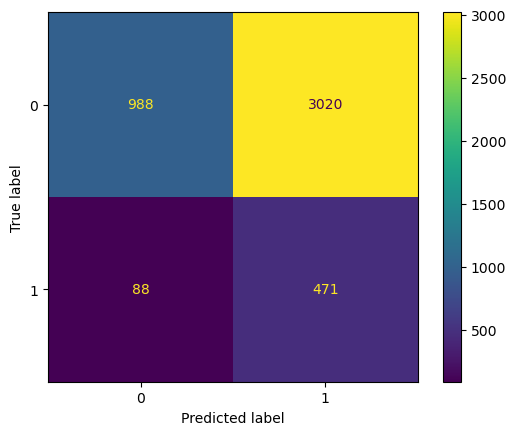

In [42]:
cm = confusion_matrix(ytest, new_preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [43]:
print(classification_report(ytest, new_preds))

              precision    recall  f1-score   support

           0       0.92      0.25      0.39      4008
           1       0.13      0.84      0.23       559

    accuracy                           0.32      4567
   macro avg       0.53      0.54      0.31      4567
weighted avg       0.82      0.32      0.37      4567



In [44]:
roc_auc_score(ytest, new_preds)

0.5445415073252422

In [46]:
false_positive_rate, true_positive_rate, threshold = roc_curve(ytest, new_preds)

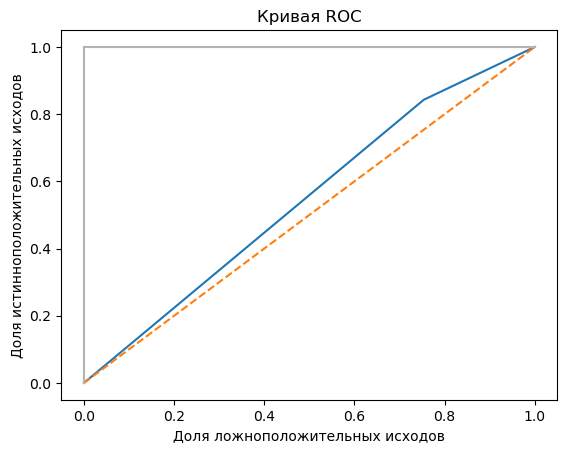

In [47]:
plt.title("Кривая ROC")
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls = '--')
plt.plot([0, 0], [1, 0] , c=".7")
plt.plot([1, 1] , c=".7")
plt.ylabel("Доля истинноположительных исходов")
plt.xlabel("Доля ложноположительных исходов")
plt.show()

Влияет ли изменение гиперпараметра C на качество модели (и, соответственно, метрики) в этой задаче?

In [48]:
# ваш вывод здесь :изменение гиперпараметра C всегда влияет на качество модели (и, соответственно, метрики), но не в этой задачe

Ответьте развёрнуто на следующие вопросы:

* Удалось ли при помощи логистической регрессии и подбора порога превзойти качество метода ближайших соседей в этой задаче? 

* Смогли ли мы при помощи этой модели получить высокий recall при ограничениях, поставленных заказчиком?


In [ ]:
# ваш вывод здесь
:1. Величина AUC низкая при любом пороге.
При несбалансированных данных при помощи логистической регрессии увиличилась величина TP, но при этом резко увеличилась и величина FP и снизился AUC с 0,61 до 0,55 (по сравнению с моделью логистической регрессии без изменения порога).
2.Да recall получился высокий на классе 1, но резко снизился на классе 0 (резкий рост FP).
Низкая устойчивость: если объекты разных классов распределены неравномерно, то алгоритмы машинного обучения могут быть неустойчивы к изменениям в распределении данных.
Но можно рассмотреть следующие варианты:
Уменьшение выборки — метод балансировки классов путем уменьшения количества образцов в преобладающем классе до уровня менее представленного класса. Это позволяет уравнять количество образцов между классами и снизить дисбаланс;
Использовать другие модели машинного обучения.
